In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv
import copy
import warnings
warnings.filterwarnings('ignore')

# name and files for the simulation studied

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'

path2 = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

In [2]:
# name and files for the simulation studied

name = '_DPPC_DIPC_chol'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'

path2 = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

In [3]:
# load gro and xtc files
u = mda.Universe( path+fgro, path+fxtc)

In [43]:
sel = u.select_atoms("all and resname DPPC")
#u.atoms[9400:9401].residues

In [44]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel)
v.add_spacefill(sel, scale=2.0)
v

A Jupyter Widget

# Diffusion

In [48]:
# boucle pour suivre un lipide pendant la trajectoire pour calculer le MSD et le coeff de diffusion
tmes = 1000
nbr = 22

traj = []
x = []
y = []

for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            #print(ts.frame)
            str_sel = "name PO4 and resname DIPC"
            p = u.select_atoms(str_sel).positions
            traj.append(p)
            
print(traj)

[array([[277.40002 , 167.19    ,  73.26    ],
       [247.90001 , 266.30002 ,  75.19    ],
       [280.00003 , 245.6     ,  73.54001 ],
       ...,
       [136.04001 , 133.24    ,  33.      ],
       [360.65002 ,  38.520004,  37.61    ],
       [338.44    , 143.3     ,  32.15    ]], dtype=float32), array([[302.27002 ,  59.610004,  73.97    ],
       [ 24.460001, 308.72003 ,  79.670006],
       [237.78001 , 300.47    ,  64.01    ],
       ...,
       [297.53003 , 345.97    ,  33.83    ],
       [332.38004 , 352.37003 ,  27.470001],
       [151.09001 ,  40.620003,  34.24    ]], dtype=float32), array([[347.37003 , 309.61002 ,  66.380005],
       [ 13.010001, 255.19    ,  65.62    ],
       [279.34003 , 367.53003 ,  50.270004],
       ...,
       [261.49002 , 207.72002 ,  24.870003],
       [ 88.66    ,   3.79    ,  32.46    ],
       [ 92.48    ,  25.960003,  35.280003]], dtype=float32), array([[ 67.090004, 320.77    ,  63.020004],
       [ 92.64001 , 280.22    ,  59.690002],
       [191.

In [49]:
traj2 = np.array(traj)
nbr=22 # indice du lipide que l'on suit
print(np.shape(traj2)) # nb de frames - indice des lipides - coordonnées

(10, 3190, 3)


In [50]:
print(len(traj2))

10


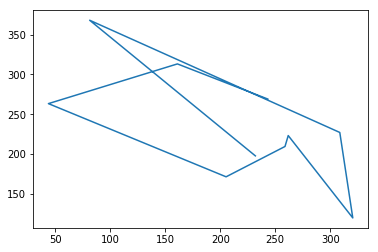

In [51]:
x=traj2[:,nbr,0]
y=traj2[:,nbr,1]
plt.plot(x,y)

In [65]:
L = 430

x2 = np.arange(len(x))
y2 = np.arange(len(x))
x2[0] = x[0]
y2[0] = y[0]

for i in range(1,len(x)):
    if (x[i]-x[i-1])<=L/2 :
        x2[i] = x[i]+L
    else:
        x2[i] = x[i]
    
    if (y[i]-y[i-1])<=L/2 :
        y2[i] = y[i]+L
    else:
        y2[i] = y[i]

[243 591 473 635 688 691 750 738 511 661]
[269 743 693 601 639 653 549 657 798 627]


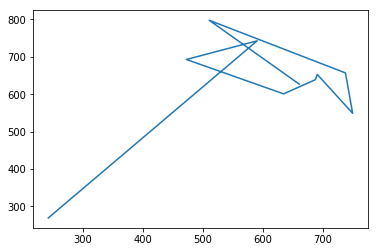

In [66]:
print(x2)
print(y2)
plt.plot(x2,y2)